In [1]:
import multiprocessing
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

In [2]:
# declarations
out_dir = "analysis_21042020/"
fig_dir = "analysis_21042020/figs/"

num_tissues = 3
num_samples = 10

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# bcbioRnaseq - both salmon and kallisto can be aggregated to the gene-level
# https://github.com/bcbio/bcbio-nextgen/issues/2077

In [3]:
# begin by loading the real data
strg_real = pd.DataFrame()
slmn_real = pd.DataFrame()
klst_real = pd.DataFrame()
for tn in range(num_tissues):
    for sn in range(num_samples):
        tmp = pd.read_csv(out_dir+"strg_real.t"+str(tn)+"_s"+str(sn)+".csv")
        strg_real = pd.concat([strg_real,tmp],axis=0)
        
        tmp = pd.read_csv(out_dir+"slmn_real.t"+str(tn)+"_s"+str(sn)+".csv")
        slmn_real = pd.concat([slmn_real,tmp],axis=0)
        
        tmp = pd.read_csv(out_dir+"klst_real.t"+str(tn)+"_s"+str(sn)+".csv")
        klst_real = pd.concat([klst_real,tmp],axis=0)

In [4]:
# now load the all data
strg_all = pd.DataFrame()
slmn_all = pd.DataFrame()
klst_all = pd.DataFrame()
for tn in range(num_tissues):
    for sn in range(num_samples):
        tmp = pd.read_csv(out_dir+"strg_all.t"+str(tn)+"_s"+str(sn)+".csv")
        strg_all = pd.concat([strg_all,tmp],axis=0)
        
        tmp = pd.read_csv(out_dir+"slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")
        slmn_all = pd.concat([slmn_all,tmp],axis=0)
        
        tmp = pd.read_csv(out_dir+"klst_all.t"+str(tn)+"_s"+str(sn)+".csv")
        klst_all = pd.concat([klst_all,tmp],axis=0)

In [5]:
# now we need to extract median, quartiles and whiskers

# calculate whiskers
def calcWhisk(row,data):
    iqr = row["q75"] - row["q25"]
    lowWhisker = float(row["q25"])-1.5*float(iqr)
    highWhisker = float(row["q75"])+1.5*float(iqr)

    wiskhi = np.max(data[data["fold"]<=highWhisker]["fold"])
    wisklo = np.min(data[data["fold"]>=lowWhisker]["fold"])
    extremesHigh = data[data["fold"]>wiskhi]["fold"].tolist()
    extremesLow = data[data["fold"]<wisklo]["fold"].tolist()

    return [wisklo,wiskhi,extremesLow+extremesHigh]

strg_real_g=pd.DataFrame([])
for frac_real in set(strg_real["frac_real"]):
    stats=pd.DataFrame()
    stats_all=strg_real[strg_real["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    strg_real_g=pd.concat([strg_real_g,stats])
strg_real_g.sort_values(by="frac_real",inplace=True)

slmn_real_g=pd.DataFrame([])
for frac_real in set(slmn_real["frac_real"]):
    stats=pd.DataFrame()
    stats_all=slmn_real[slmn_real["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    slmn_real_g=pd.concat([slmn_real_g,stats])
slmn_real_g.sort_values(by="frac_real",inplace=True)

klst_real_g=pd.DataFrame([])
for frac_real in set(klst_real["frac_real"]):
    stats=pd.DataFrame()
    stats_all=klst_real[klst_real["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    klst_real_g=pd.concat([klst_real_g,stats])
klst_real_g.sort_values(by="frac_real",inplace=True)

strg_all_g=pd.DataFrame([])
for frac_real in set(strg_all["frac_real"]):
    stats=pd.DataFrame()
    stats_all=strg_all[strg_all["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    strg_all_g=pd.concat([strg_all_g,stats])
strg_all_g.sort_values(by="frac_real",inplace=True)

slmn_all_g=pd.DataFrame([])
for frac_real in set(slmn_all["frac_real"]):
    stats=pd.DataFrame()
    stats_all=slmn_all[slmn_all["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    slmn_all_g=pd.concat([slmn_all_g,stats])
slmn_all_g.sort_values(by="frac_real",inplace=True)

klst_all_g=pd.DataFrame([])
for frac_real in set(klst_all["frac_real"]):
    stats=pd.DataFrame()
    stats_all=klst_all[klst_all["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    klst_all_g=pd.concat([klst_all_g,stats])
klst_all_g.sort_values(by="frac_real",inplace=True)

slmn_all_g

,q25,median,q75,mean,whiskLow,whiskHigh,extremes,frac_real
0,9.336083,18.998189,34.113314,78.639069,-0.636937,70.512820,"[84.8522823068182, 77.57035094666666, 163.4032...",0.0
0,2.530579,4.980531,7.662278,5.760154,-0.834000,15.359477,"[18.37780101343284, 17.9128209245283, 15.52376...",0.1
0,1.369521,2.436896,3.458203,2.490930,-0.798310,6.554020,"[7.712720470588236, 9.326476511627906, 8.12942...",0.2
0,0.906716,1.504284,2.000625,1.486257,-0.728155,3.632761,"[-0.7991451941923775, -0.8039830015455951, -0....",0.3
0,0.569148,0.994323,1.286411,0.942729,-0.506329,2.337578,"[-0.7570754716981132, -0.5316973415132924, -0....",0.4
0,0.392209,0.653417,0.856076,0.703204,-0.300167,1.549156,"[-0.44395769615384617, -0.3149199060773481, -0...",0.5
0,0.244108,0.438841,0.576007,0.493987,-0.253676,1.072781,"[-0.4368516606189967, -0.3928373993550788, -0....",0.6
0,0.090178,0.248678,0.353136,0.209236,-0.303463,0.746053,"[-0.3926900177058304, -0.3387567855652899, -0....",0.7
0,0.000000,0.134907,0.211089,0.138240,-0.316492,0.525971,"[-0.7121866815038893, -0.34165983635300995, -0...",0.8
0,-0.096142,0.033177,0.089783,-0.026150,-0.375027,0.368286,"[-0.7589041095890411, -0.38511905676855895, -0...",0.9


In [6]:
# now need to plot false positives and false negatives
strg_real_nfp = []
slmn_real_nfp = []
klst_real_nfp = []

strg_real_nfn = []
slmn_real_nfn = []
klst_real_nfn = []

strg_all_nfp = []
slmn_all_nfp = []
klst_all_nfp = []

strg_all_nfn = []
slmn_all_nfn = []
klst_all_nfn = []
for tn in range(num_tissues):
    for sn in range(num_samples):
        strg_real_nfp.append(len(pd.read_csv(out_dir+"fp_strg_real.t"+str(tn)+"_s"+str(sn)+".csv")))
        slmn_real_nfp.append(len(pd.read_csv(out_dir+"fp_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv")))
        klst_real_nfp.append(len(pd.read_csv(out_dir+"fp_klst_real.t"+str(tn)+"_s"+str(sn)+".csv")))

        strg_all_nfp.append(len(pd.read_csv(out_dir+"fp_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")))
        slmn_all_nfp.append(len(pd.read_csv(out_dir+"fp_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")))
        klst_all_nfp.append(len(pd.read_csv(out_dir+"fp_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")))

        strg_real_nfn.append(len(pd.read_csv(out_dir+"fn_strg_real.t"+str(tn)+"_s"+str(sn)+".csv")))
        slmn_real_nfn.append(len(pd.read_csv(out_dir+"fn_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv")))
        klst_real_nfn.append(len(pd.read_csv(out_dir+"fn_klst_real.t"+str(tn)+"_s"+str(sn)+".csv")))

        strg_all_nfn.append(len(pd.read_csv(out_dir+"fn_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")))
        slmn_all_nfn.append(len(pd.read_csv(out_dir+"fn_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")))
        klst_all_nfn.append(len(pd.read_csv(out_dir+"fn_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")))

In [7]:
# now build dataframe for fps and fns separate and plot them into 2 columns of a figure
strg_real_nfp_df = pd.DataFrame(strg_real_nfp)
strg_real_nfp_df["method"]="StringTie2"
strg_real_nfp_df["type"]="Real"
slmn_real_nfp_df = pd.DataFrame(slmn_real_nfp)
slmn_real_nfp_df["method"]="Salmon"
slmn_real_nfp_df["type"]="Real"
klst_real_nfp_df = pd.DataFrame(klst_real_nfp)
klst_real_nfp_df["method"]="Kallisto"
klst_real_nfp_df["type"]="Real"

strg_all_nfp_df = pd.DataFrame(strg_all_nfp)
strg_all_nfp_df["method"]="StringTie2"
strg_all_nfp_df["type"]="All"
slmn_all_nfp_df = pd.DataFrame(slmn_all_nfp)
slmn_all_nfp_df["method"]="Salmon"
slmn_all_nfp_df["type"]="All"
klst_all_nfp_df = pd.DataFrame(klst_all_nfp)
klst_all_nfp_df["method"]="Kallisto"
klst_all_nfp_df["type"]="All"


strg_real_nfn_df = pd.DataFrame(strg_real_nfn)
strg_real_nfn_df["method"]="StringTie2"
strg_real_nfn_df["type"]="Real"
slmn_real_nfn_df = pd.DataFrame(slmn_real_nfn)
slmn_real_nfn_df["method"]="Salmon"
slmn_real_nfn_df["type"]="Real"
klst_real_nfn_df = pd.DataFrame(klst_real_nfn)
klst_real_nfn_df["method"]="Kallisto"
klst_real_nfn_df["type"]="Real"

strg_all_nfn_df = pd.DataFrame(strg_all_nfn)
strg_all_nfn_df["method"]="StringTie2"
strg_all_nfn_df["type"]="All"
slmn_all_nfn_df = pd.DataFrame(slmn_all_nfn)
slmn_all_nfn_df["method"]="Salmon"
slmn_all_nfn_df["type"]="All"
klst_all_nfn_df = pd.DataFrame(klst_all_nfn)
klst_all_nfn_df["method"]="Kallisto"
klst_all_nfn_df["type"]="All"

fp_df = pd.concat([strg_real_nfp_df,slmn_real_nfp_df,klst_real_nfp_df,strg_all_nfp_df,slmn_all_nfp_df,klst_all_nfp_df])
fn_df = pd.concat([strg_real_nfn_df,slmn_real_nfn_df,klst_real_nfn_df,strg_all_nfn_df,slmn_all_nfn_df,klst_all_nfn_df])
fp_df.columns = ["nfp","method","type"]
fn_df.columns = ["nfn","method","type"]
fp_df.head()

,nfp,method,type
0,714,StringTie2,Real
1,643,StringTie2,Real
2,616,StringTie2,Real
3,636,StringTie2,Real
4,676,StringTie2,Real


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


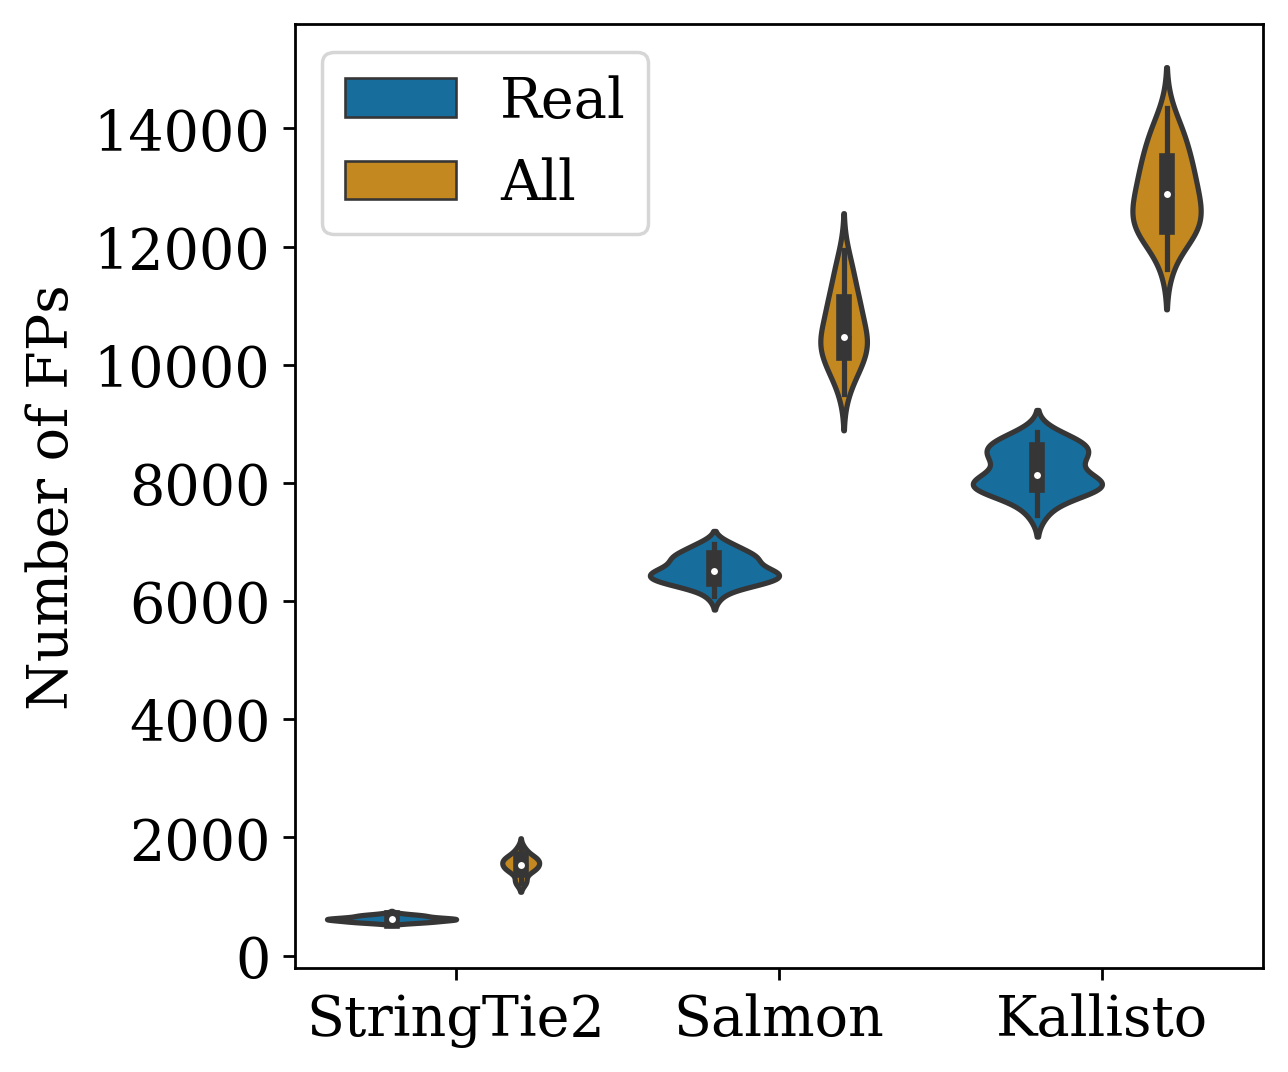

In [8]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(5,5),dpi=250)
# sns.set(style="ticks",palette="colorblind", color_codes=True)
ax = sns.violinplot(x="method", y="nfp", hue="type",data=fp_df,palette="colorblind")
ax.set_xlabel("")
# plt.title("Rate of False Positive Gene Quantification")
ax.set_ylabel("Number of FPs")
legend = plt.legend()
fig.savefig(fig_dir+"gene_fp.eps", format='eps')

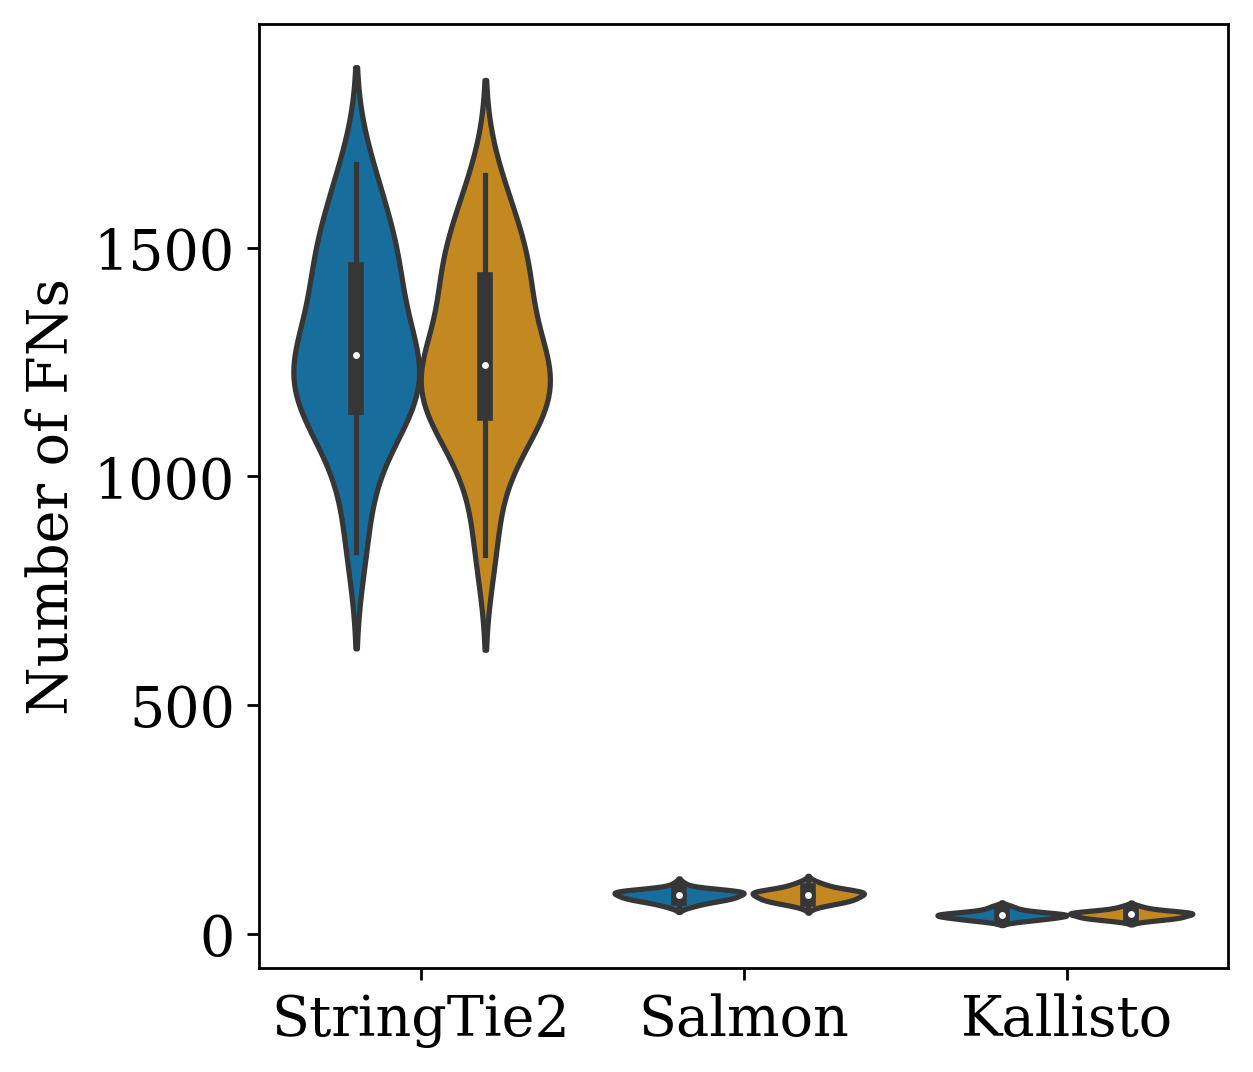

In [9]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(5,5),dpi=250)
sns.violinplot(x="method", y="nfn", hue="type",data=fn_df,palette="colorblind")
# plt.title("Rate of False negative Gene Quantification")
plt.xlabel("")
plt.ylabel("Number of FNs")
legend = plt.legend()
plt.legend().remove()
fig.savefig(fig_dir+"gene_fn.eps", format='eps')

In [10]:
strg_all_g

,q25,median,q75,mean,whiskLow,whiskHigh,extremes,frac_real
0,-0.819366,-0.229044,1.344295,7.063202,-0.999954,4.583758,"[17.976558999999995, 4.890895445277362, 5.3255...",0.0
0,-0.735764,-0.282962,0.259060,0.218890,-0.999951,1.750159,"[2.9750519099999995, 2.8821313488435374, 1.829...",0.1
0,-0.689125,-0.314693,0.080533,0.000614,-0.999891,1.233009,"[6.404050799472295, 3.4795658012820505, 1.5243...",0.2
0,-0.635630,-0.303937,0.023680,-0.099057,-0.999791,1.004621,"[1.784088103896104, 2.2122233926892947, 2.1849...",0.3
0,-0.607858,-0.245805,0.070524,-0.170197,-0.999982,1.088003,"[3.231277589932473, 1.3921747597338243, 1.5237...",0.4
0,-0.589751,-0.202184,0.123659,-0.161166,-0.999957,1.192308,"[1.341543486673248, 1.3463970540540535, 16.045...",0.5
0,-0.498882,-0.130657,0.136173,-0.137255,-0.999972,1.079709,"[1.736459553378762, 1.712001445465538, 1.47763...",0.6
0,-0.491251,-0.124262,0.090503,-0.193630,-0.999991,0.945555,"[2.0818568810457525, 3.8466530745762713, 1.200...",0.7
0,-0.493761,-0.135440,0.037312,-0.228084,-0.999993,0.831752,"[1.096909566020314, 0.940135190625, 1.32651261...",0.8
0,-0.500948,-0.155273,-0.000504,-0.254843,-0.999992,0.744537,"[2.4809968967337515, 8.516206402985071, 0.9320...",0.9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


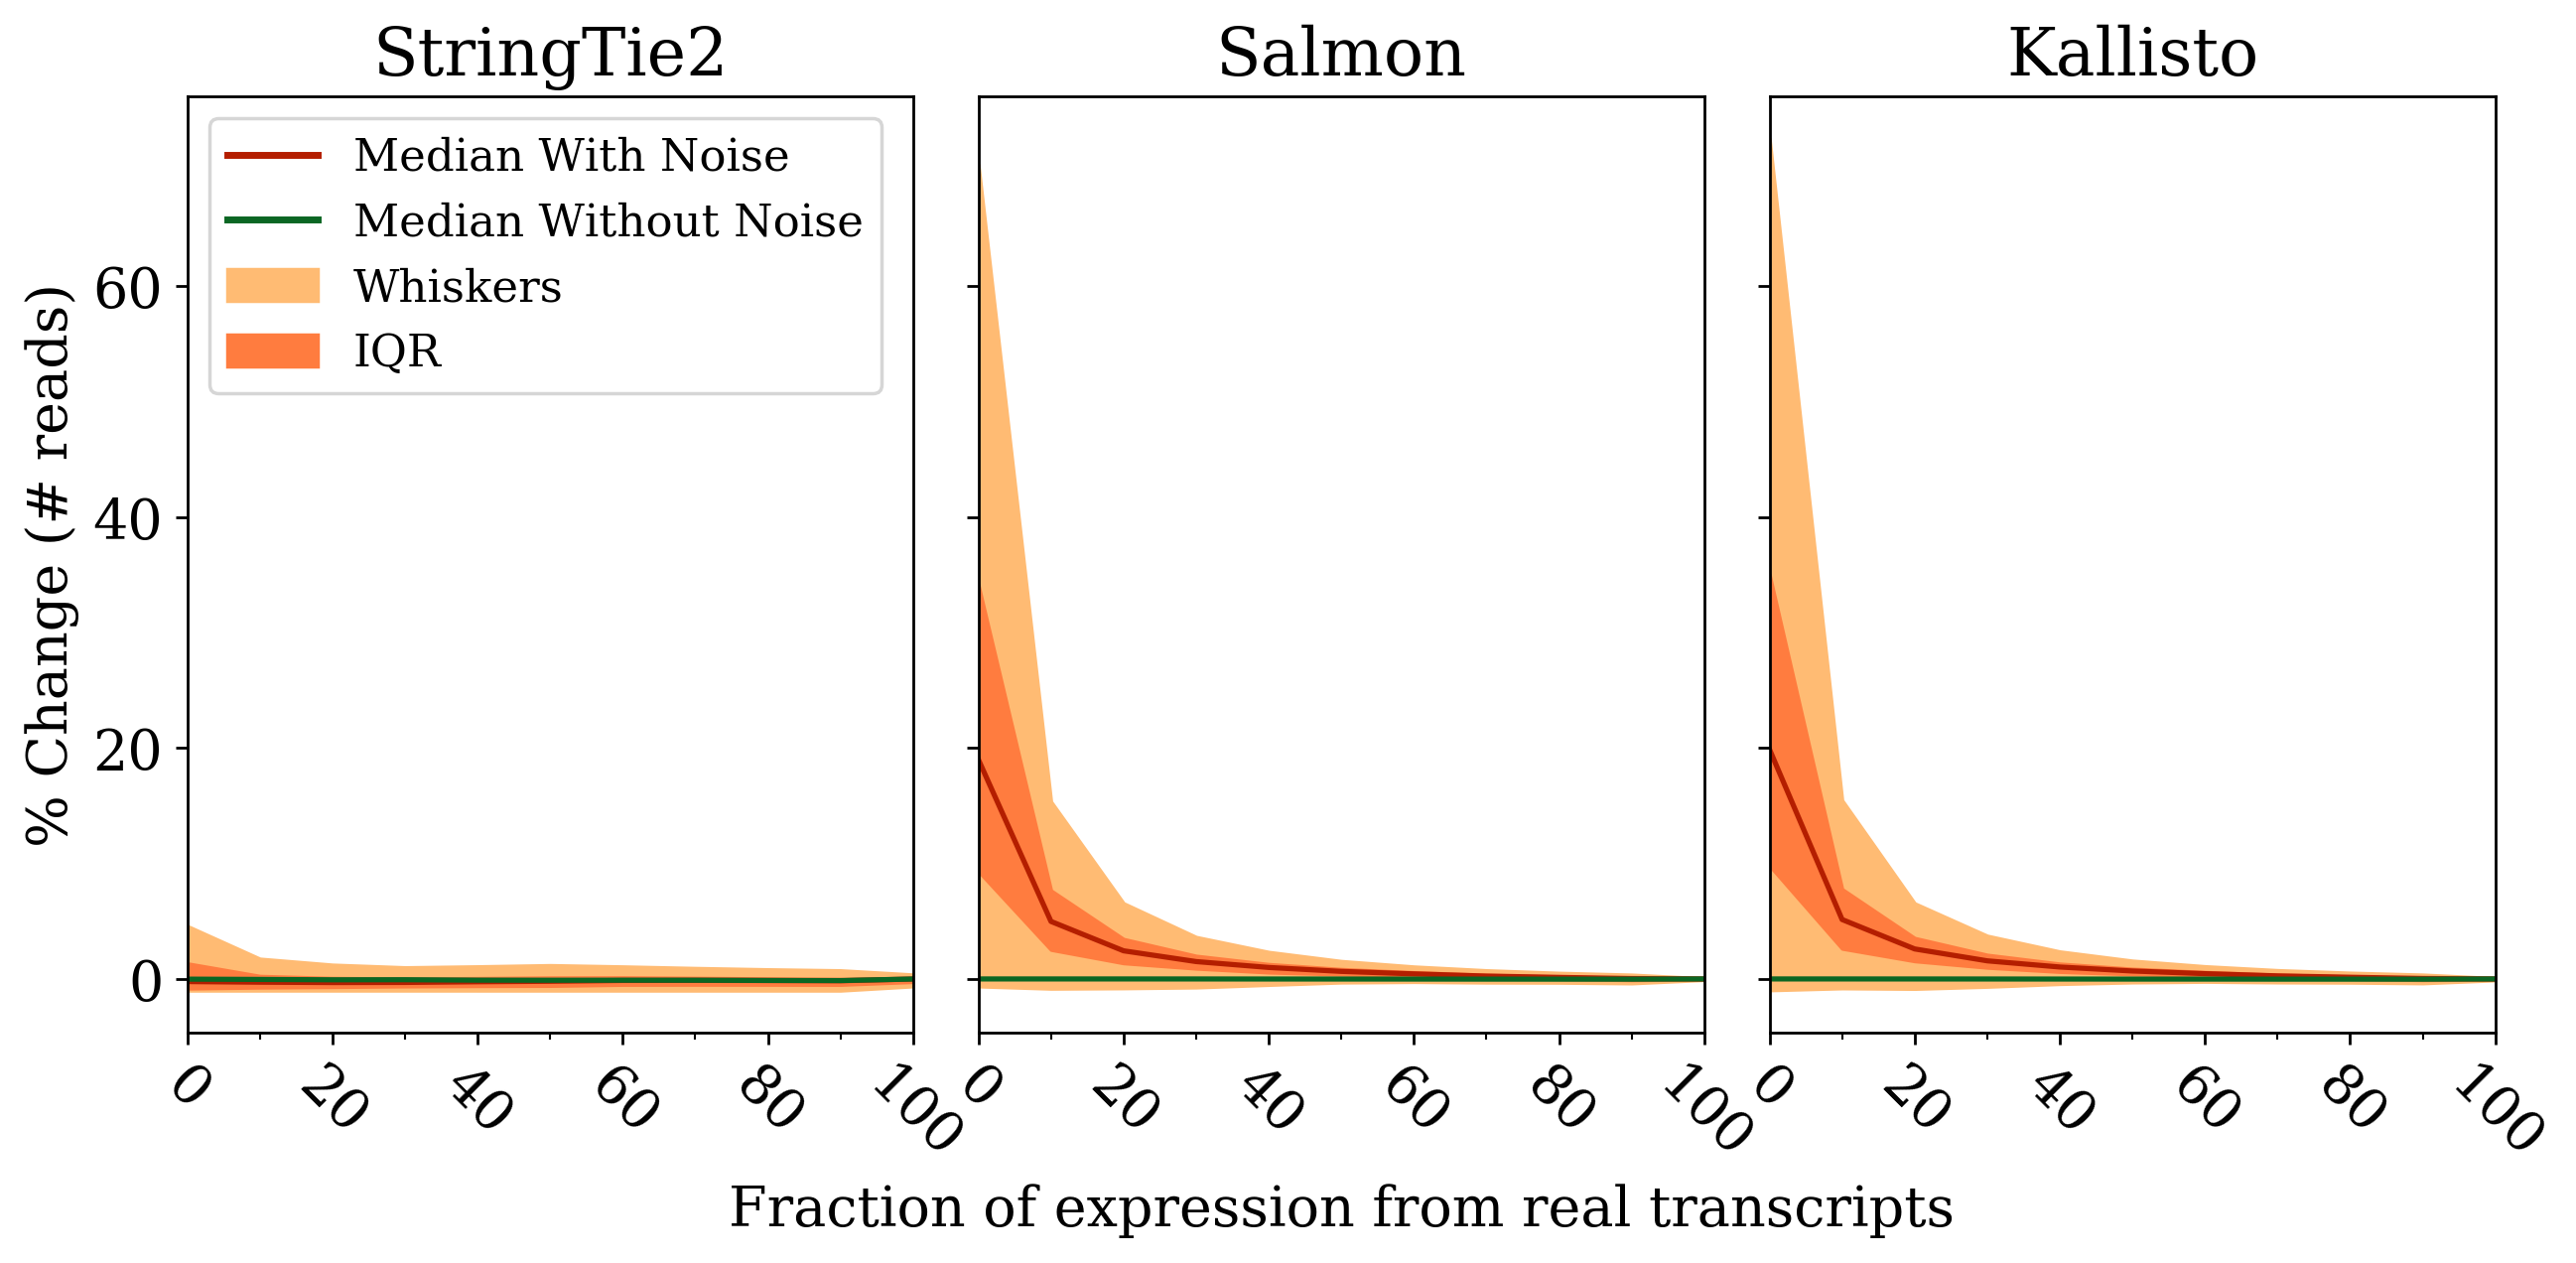

In [11]:
###### now we can finally plot everything
plt.rcParams['font.size'] = 16
fig,axes = plt.subplots(nrows=1,ncols=3,sharey=True,sharex=True,figsize=(12,5),dpi=250)

# fig.suptitle("Change in gene-level expression estimate from truth as a function\nof the fraction of real transcription per gene", fontsize=16)

ticks = [int(x*100) for x in strg_all_g["frac_real"]]
print(ticks)

axes[0].plot(ticks, strg_all_g["median"],'k',color='#b41e00',label="with noise")
axes[0].plot(ticks, strg_real_g["median"],'k',color='#0B6623',label="without noise")
axes[0].set_xticks(ticks)
axes[0].fill_between(ticks, strg_all_g["whiskLow"], strg_all_g["whiskHigh"],
    edgecolor='#ffbb73', facecolor='#ffbb73')
axes[0].fill_between(ticks, strg_all_g["q25"], strg_all_g["q75"],
    edgecolor='#ff7c3f', facecolor='#ff7c3f')
axes[0].set_title("StringTie2")
axes[0].set_ylabel("% Change (# reads)")

axes[1].plot(ticks, slmn_all_g["median"],'k',color='#b41e00')
axes[1].plot(ticks, slmn_real_g["median"],'k',color='#0B6623')
axes[1].set_xticks(ticks)
axes[1].fill_between(ticks, slmn_all_g["whiskLow"], slmn_all_g["whiskHigh"],
    edgecolor='#ffbb73', facecolor='#ffbb73')
axes[1].fill_between(ticks, slmn_all_g["q25"], slmn_all_g["q75"],
    edgecolor='#ff7c3f', facecolor='#ff7c3f')
axes[1].set_title("Salmon")
axes[1].set_xlabel("Fraction of expression from real transcripts")

axes[2].plot(ticks, klst_all_g["median"],'k',color='#b41e00')
axes[2].plot(ticks, klst_real_g["median"],'k',color='#0B6623')
plt.xlim(min(ticks),max(ticks))
axes[2].set_xticks(ticks)
axes[2].fill_between(ticks, klst_all_g["whiskLow"], klst_all_g["whiskHigh"],
    edgecolor='#ffbb73', facecolor='#ffbb73')
axes[2].fill_between(ticks, klst_all_g["q25"], klst_all_g["q75"],
    edgecolor='#ff7c3f', facecolor='#ff7c3f')
axes[2].set_title("Kallisto")

legend_elements = [Line2D([0], [0], color='#b41e00', lw=2, label='Median With Noise'),
                   Line2D([0], [0], color='#0B6623', lw=2, label='Median Without Noise'),
                   Patch(facecolor='#ffbb73', edgecolor='#ffbb73',label='Whiskers'),
                   Patch(facecolor='#ff7c3f', edgecolor='#ff7c3f',label='IQR')]

axes[0].legend(handles=legend_elements,fontsize=13,loc='upper left')

axes[0].xaxis.set_major_locator(MultipleLocator(20))
axes[0].xaxis.set_minor_locator(MultipleLocator(10))

# plt.tight_layout()
plt.subplots_adjust(wspace = .09)
plt.setp(axes[0].xaxis.get_majorticklabels(),rotation=-45)
plt.setp(axes[1].xaxis.get_majorticklabels(),rotation=-45)
plt.setp(axes[2].xaxis.get_majorticklabels(),rotation=-45)

fig.savefig(fig_dir+"gene_fold.eps", format='eps')

In [12]:
# now we need to extract median, quartiles and whiskers

strg_real_g=pd.DataFrame([])
strg_real["frac_noise"] = 1-strg_real["frac_real"]
for frac_noise in set(strg_real["frac_noise"]):
    stats=pd.DataFrame()
    stats_all=strg_real[strg_real["frac_noise"]==frac_noise][["frac_noise","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_noise"]=frac_noise
    strg_real_g=pd.concat([strg_real_g,stats])
strg_real_g.sort_values(by="frac_noise",inplace=True,ascending=True)

slmn_real_g=pd.DataFrame([])
slmn_real["frac_noise"] = 1-slmn_real["frac_real"]
for frac_noise in set(slmn_real["frac_noise"]):
    stats=pd.DataFrame()
    stats_all=slmn_real[slmn_real["frac_noise"]==frac_noise][["frac_noise","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_noise"]=frac_noise
    slmn_real_g=pd.concat([slmn_real_g,stats])
slmn_real_g.sort_values(by="frac_noise",inplace=True,ascending=True)

klst_real_g=pd.DataFrame([])
klst_real["frac_noise"] = 1-klst_real["frac_real"]
for frac_noise in set(klst_real["frac_noise"]):
    stats=pd.DataFrame()
    stats_all=klst_real[klst_real["frac_noise"]==frac_noise][["frac_noise","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_noise"]=frac_noise
    klst_real_g=pd.concat([klst_real_g,stats])
klst_real_g.sort_values(by="frac_noise",inplace=True,ascending=True)

strg_all_g=pd.DataFrame([])
strg_all["frac_noise"] = 1-strg_all["frac_real"]
for frac_noise in set(strg_all["frac_noise"]):
    stats=pd.DataFrame()
    stats_all=strg_all[strg_all["frac_noise"]==frac_noise][["frac_noise","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_noise"]=frac_noise
    strg_all_g=pd.concat([strg_all_g,stats])
strg_all_g.sort_values(by="frac_noise",inplace=True,ascending=True)

slmn_all_g=pd.DataFrame([])
slmn_all["frac_noise"] = 1-slmn_all["frac_real"]
for frac_noise in set(slmn_all["frac_noise"]):
    stats=pd.DataFrame()
    stats_all=slmn_all[slmn_all["frac_noise"]==frac_noise][["frac_noise","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_noise"]=frac_noise
    slmn_all_g=pd.concat([slmn_all_g,stats])
slmn_all_g.sort_values(by="frac_noise",inplace=True,ascending=True)

klst_all_g=pd.DataFrame([])
klst_all["frac_noise"] = 1-klst_all["frac_real"]
for frac_noise in set(klst_all["frac_noise"]):
    stats=pd.DataFrame()
    stats_all=klst_all[klst_all["frac_noise"]==frac_noise][["frac_noise","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_noise"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_noise"]=frac_noise
    klst_all_g=pd.concat([klst_all_g,stats])
klst_all_g.sort_values(by="frac_noise",inplace=True,ascending=True)

slmn_all_g

,q25,median,q75,mean,whiskLow,whiskHigh,extremes,frac_noise
0,-0.032027,0.000000,0.000000,3.837077,-0.080044,0.048035,"[-0.09306392287409364, -0.5956473987193394, -0...",0.0
0,-0.096142,0.033177,0.089783,-0.026150,-0.375027,0.368286,"[-0.7589041095890411, -0.38511905676855895, -0...",0.1
0,0.000000,0.134907,0.211089,0.138240,-0.316492,0.525971,"[-0.7121866815038893, -0.34165983635300995, -0...",0.2
0,0.090178,0.248678,0.353136,0.209236,-0.303463,0.746053,"[-0.3926900177058304, -0.3387567855652899, -0....",0.3
0,0.244108,0.438841,0.576007,0.493987,-0.253676,1.072781,"[-0.4368516606189967, -0.3928373993550788, -0....",0.4
0,0.392209,0.653417,0.856076,0.703204,-0.300167,1.549156,"[-0.44395769615384617, -0.3149199060773481, -0...",0.5
0,0.569148,0.994323,1.286411,0.942729,-0.506329,2.337578,"[-0.7570754716981132, -0.5316973415132924, -0....",0.6
0,0.906716,1.504284,2.000625,1.486257,-0.728155,3.632761,"[-0.7991451941923775, -0.8039830015455951, -0....",0.7
0,1.369521,2.436896,3.458203,2.490930,-0.798310,6.554020,"[7.712720470588236, 9.326476511627906, 8.12942...",0.8
0,2.530579,4.980531,7.662278,5.760154,-0.834000,15.359477,"[18.37780101343284, 17.9128209245283, 15.52376...",0.9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0, 9, 19, 30, 40, 50, 60, 70, 80, 90, 100]


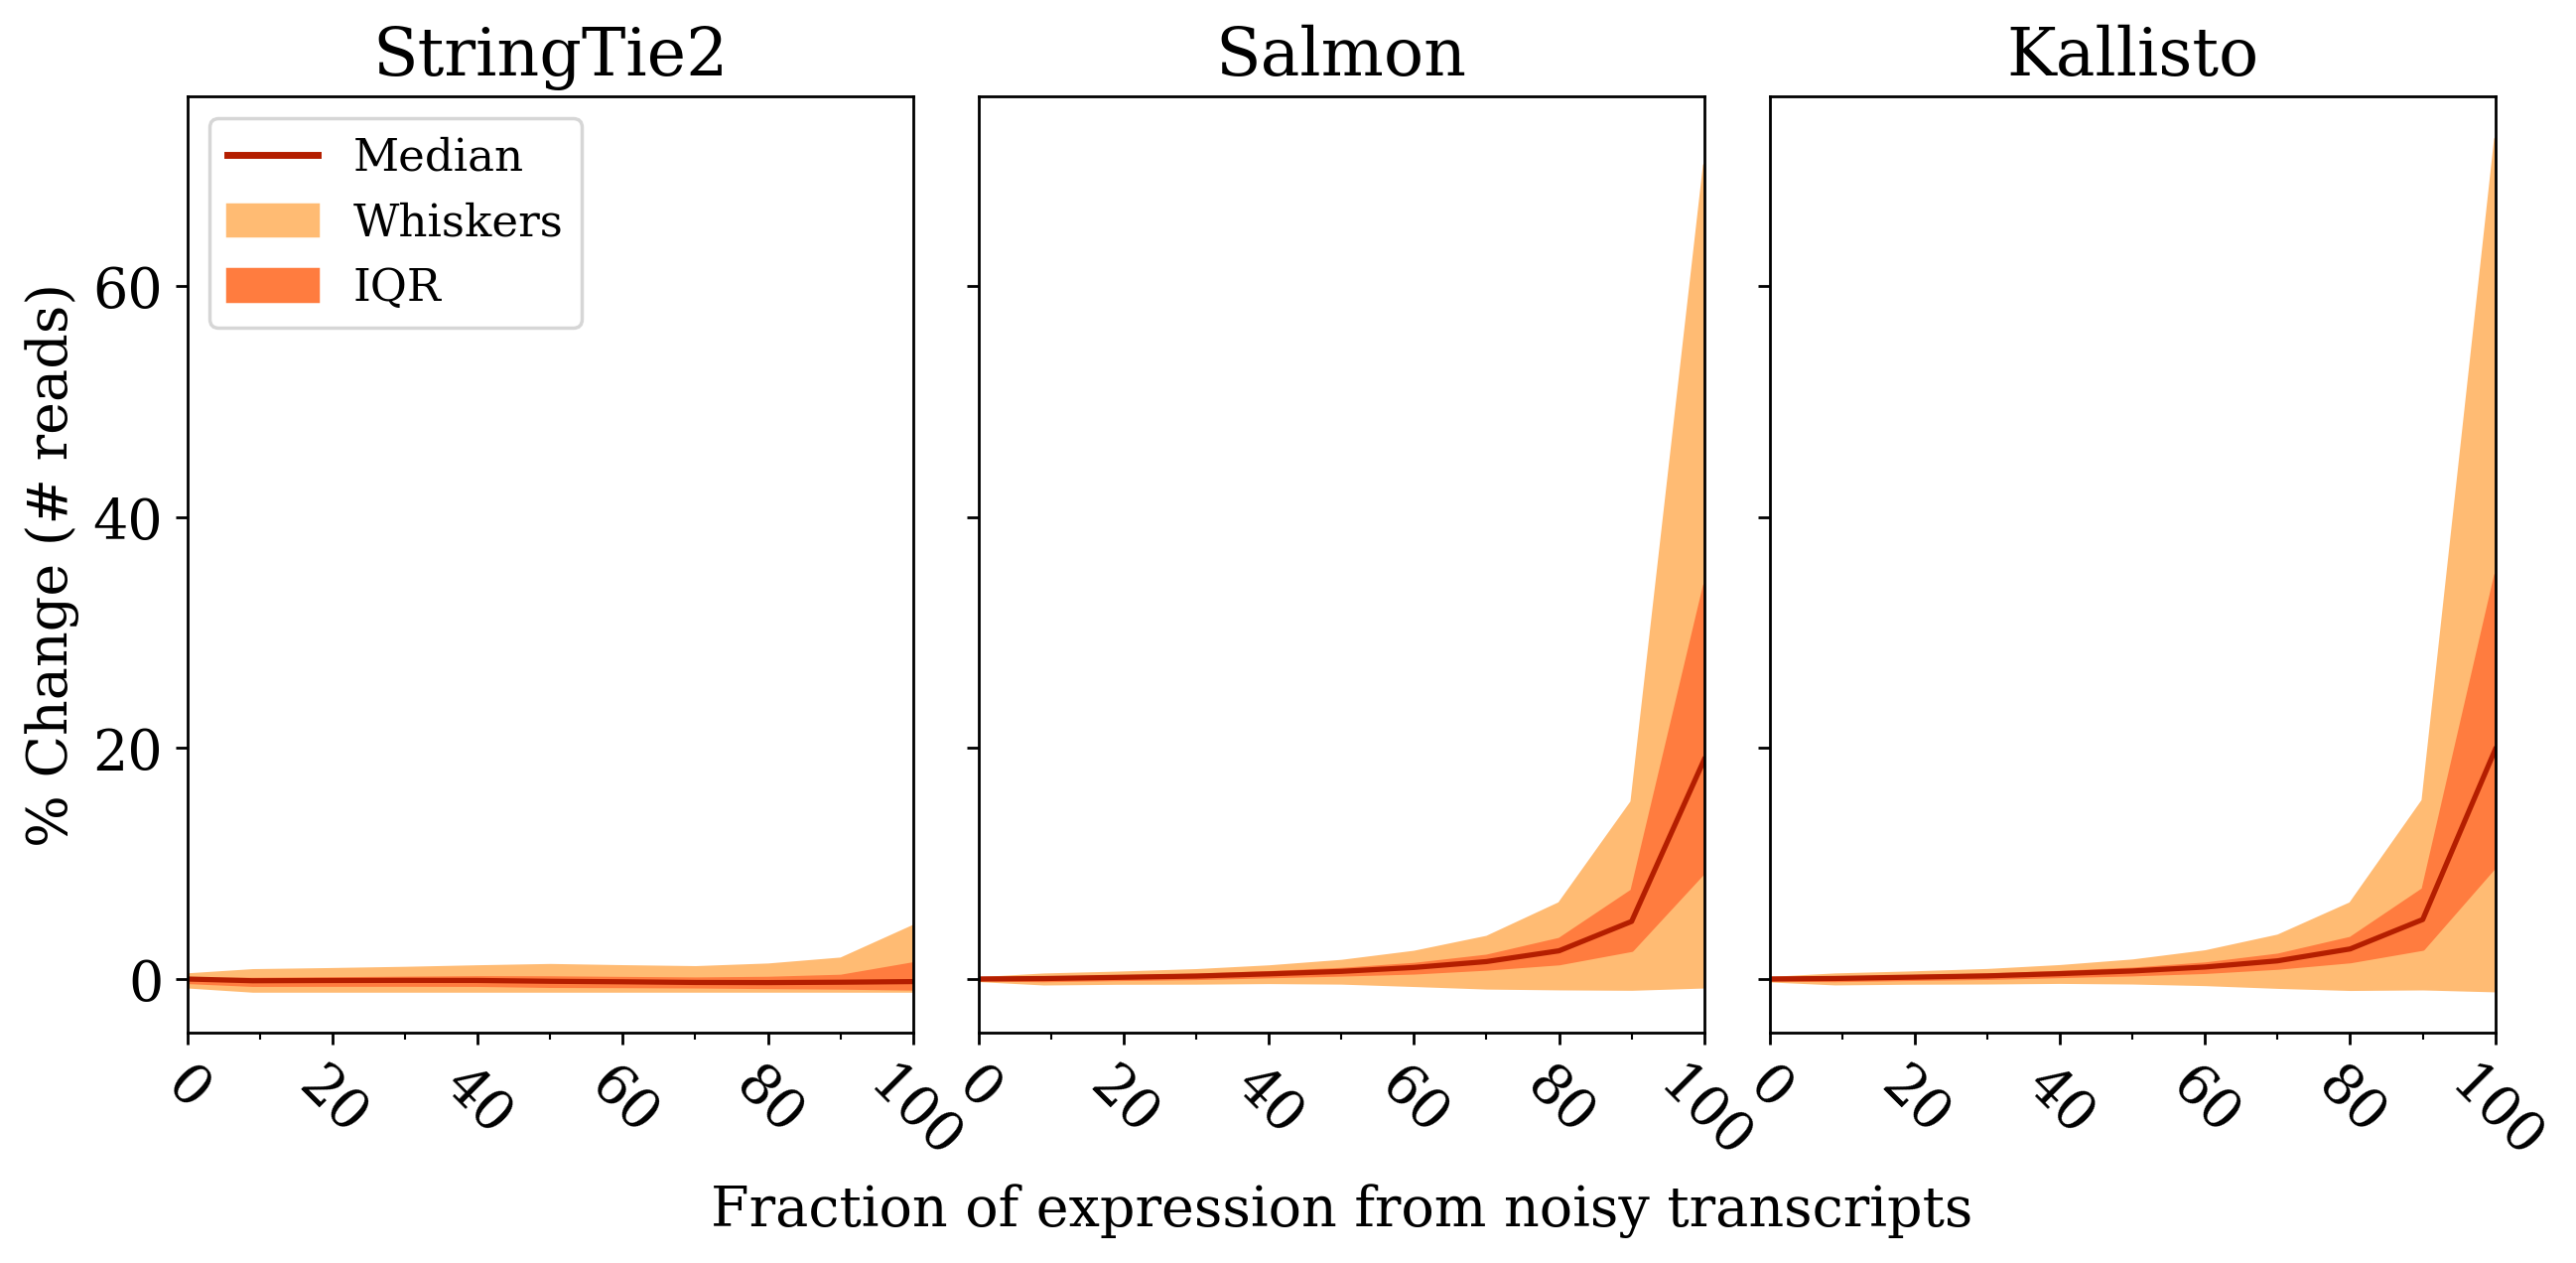

In [13]:
###### now we can finally plot everything
plt.rcParams['font.size'] = 16
fig,axes = plt.subplots(nrows=1,ncols=3,sharey=True,sharex=True,figsize=(12,5),dpi=250)

# fig.suptitle("Change in gene-level expression estimate from truth as a function\nof the fraction of real transcription per gene", fontsize=16)

ticks = [int(x*100) for x in strg_all_g["frac_noise"]]
print(ticks)

axes[0].plot(ticks, strg_all_g["median"],'k',color='#b41e00',label="with noise")
axes[0].set_xticks(ticks)
axes[0].fill_between(ticks, strg_all_g["whiskLow"], strg_all_g["whiskHigh"],
    edgecolor='#ffbb73', facecolor='#ffbb73')
axes[0].fill_between(ticks, strg_all_g["q25"], strg_all_g["q75"],
    edgecolor='#ff7c3f', facecolor='#ff7c3f')
axes[0].set_title("StringTie2")
axes[0].set_ylabel("% Change (# reads)")

axes[1].plot(ticks, slmn_all_g["median"],'k',color='#b41e00')
axes[1].set_xticks(ticks)
axes[1].fill_between(ticks, slmn_all_g["whiskLow"], slmn_all_g["whiskHigh"],
    edgecolor='#ffbb73', facecolor='#ffbb73')
axes[1].fill_between(ticks, slmn_all_g["q25"], slmn_all_g["q75"],
    edgecolor='#ff7c3f', facecolor='#ff7c3f')
axes[1].set_title("Salmon")
axes[1].set_xlabel("Fraction of expression from noisy transcripts")

axes[2].plot(ticks, klst_all_g["median"],'k',color='#b41e00')
plt.xlim(min(ticks),max(ticks))
axes[2].set_xticks(ticks)
axes[2].fill_between(ticks, klst_all_g["whiskLow"], klst_all_g["whiskHigh"],
    edgecolor='#ffbb73', facecolor='#ffbb73')
axes[2].fill_between(ticks, klst_all_g["q25"], klst_all_g["q75"],
    edgecolor='#ff7c3f', facecolor='#ff7c3f')
axes[2].set_title("Kallisto")

legend_elements = [Line2D([0], [0], color='#b41e00', lw=2, label='Median'),
                   Patch(facecolor='#ffbb73', edgecolor='#ffbb73',label='Whiskers'),
                   Patch(facecolor='#ff7c3f', edgecolor='#ff7c3f',label='IQR')]

axes[0].legend(handles=legend_elements,fontsize=13,loc='upper left')

axes[0].xaxis.set_major_locator(MultipleLocator(20))
axes[0].xaxis.set_minor_locator(MultipleLocator(10))

# plt.tight_layout()
plt.subplots_adjust(wspace = .09)
plt.setp(axes[0].xaxis.get_majorticklabels(),rotation=-45)
plt.setp(axes[1].xaxis.get_majorticklabels(),rotation=-45)
plt.setp(axes[2].xaxis.get_majorticklabels(),rotation=-45)

fig.savefig(fig_dir+"gene_fold_noise.eps", format='eps')